In [2]:
# running pyspark locally
# setup instructions: https://sparkbyexamples.com/pyspark/install-pyspark-in-anaconda-jupyter-notebook/
import pyspark
import pandas as pd         
import matplotlib.pyplot as plt
import numpy as np
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from matplotlib.ticker import FuncFormatter

spark = SparkSession \
	    .builder \
	    .appName('NYC Covid-19 Transportation Analysis - Subway') \
	    .getOrCreate()

In [3]:
# load the csv file
subway2019 = spark.read.csv(path = '../data/subway/subway2019.csv', header = True)
subway2020 = spark.read.csv(path = '../data/subway/subway2020.csv', header = True)
subway2022 = spark.read.csv(path = '../data/subway/subway2022.csv', header = True)

In [4]:
# examine each DataFrame
subway2019.limit(5).toPandas()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,17538854,7031168
1,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,14983900,14554087
2,A033,R170,02-06-00,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,769115,559221
3,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,7191422,8417203
4,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,71047673,20925389


In [5]:
subway2020.limit(5).toPandas()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,03:00:00,REGULAR,7511448,2558786
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,07:00:00,REGULAR,7511451,2558789
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,11:00:00,REGULAR,7511461,2558813
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,15:00:00,REGULAR,7511495,2558831
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2021,19:00:00,REGULAR,7511620,2558857


In [6]:
subway2022.limit(5).toPandas()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,03:00:00,REGULAR,0007675872,0002649548 ...
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,07:00:00,REGULAR,0007675876,0002649551 ...
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,11:00:00,REGULAR,0007675887,0002649594 ...
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,15:00:00,REGULAR,0007675895,0002649626 ...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,19:00:00,REGULAR,0007675920,0002649657 ...


In [7]:
# use regexp_replace to remove leading 0's from subway2022's 'Entries' and 'Exists' columns,
# however keeping a single 0 for values that consist only of zeros
subway2022 = subway2022.withColumn('Entries', regexp_replace(subway2022.Entries, '^0+(?!$)', ''))
subway2022 = subway2022.withColumn('Exits', regexp_replace(subway2022.Exits, '^0+(?!$)', ''))

# examine the modified DataFrame
subway2022.limit(5).toPandas()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,03:00:00,REGULAR,7675872,2649548 ...
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,07:00:00,REGULAR,7675876,2649551 ...
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,11:00:00,REGULAR,7675887,2649594 ...
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,15:00:00,REGULAR,7675895,2649626 ...
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/01/2022,19:00:00,REGULAR,7675920,2649657 ...


In [8]:
# number of rows and cols in each DataFrame
print('subway2019: ({}, {})'.format(subway2019.count(), len(subway2019.columns)))
print('subway2020: ({}, {})'.format(subway2020.count(), len(subway2020.columns)))
print('subway2022: ({}, {})'.format(subway2022.count(), len(subway2022.columns)))

subway2019: (10467101, 11)


subway2020: (13318000, 11)


subway2022: (11174031, 11)


In [9]:
# remove duplicate entries
subway2019 = subway2019.distinct()
subway2020 = subway2020.distinct()
subway2022 = subway2022.distinct()

In [10]:
# make sure each DataFrame only includes entries with the right year
subway2019 = subway2019.filter(substring(col('Date'), -4, 4).like('2019'))
subway2020 = subway2020.filter(substring(col('Date'), -4, 4).like('2020'))
subway2022 = subway2022.filter(substring(col('Date'), -4, 4).like('2022'))

In [11]:
# create a new column based on column 'C/A', 'Unit', and 'SCP' in order to uniquely identify a turnstile
subway2019 = subway2019.withColumn('TurnstileID', concat(col('C/A'), col('Unit'), col('SCP')))
subway2020 = subway2020.withColumn('TurnstileID', concat(col('C/A'), col('Unit'), col('SCP')))
subway2022 = subway2022.withColumn('TurnstileID', concat(col('C/A'), col('Unit'), col('SCP')))

In [12]:
# examine the modified DataFrame
subway2019.limit(5).toPandas()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,TurnstileID
0,B020,R263,00-06-03,AVENUE H,BQ,BMT,12/17/2019,19:00:00,REGULAR,0,297,B020R26300-06-03
1,B020,R263,00-06-05,AVENUE H,BQ,BMT,11/26/2019,03:00:00,REGULAR,0,67,B020R26300-06-05
2,G015,R312,01-05-01,W 8 ST-AQUARIUM,FQ,BMT,11/28/2019,03:00:00,REGULAR,0,721,G015R31201-05-01
3,G015,R312,01-05-01,W 8 ST-AQUARIUM,FQ,BMT,12/04/2019,03:00:00,REGULAR,0,721,G015R31201-05-01
4,G015,R312,01-05-01,W 8 ST-AQUARIUM,FQ,BMT,12/11/2019,15:00:00,REGULAR,0,721,G015R31201-05-01


In [13]:
# examine the shape of each DataFrame after data cleaning, the data is now ready to use
print('subway2019: ({}, {})'.format(subway2019.count(), len(subway2019.columns)))
print('subway2020: ({}, {})'.format(subway2020.count(), len(subway2020.columns)))
print('subway2022: ({}, {})'.format(subway2022.count(), len(subway2022.columns)))

subway2019: (9969156, 12)


subway2020: (10463274, 12)


subway2022: (10993256, 12)


In [14]:
# find each turnstile's daily entry counts in 2019
turnstile_daily_entry_count_2019 = (subway2019.groupBy('TurnstileID', 'Date')
                             .agg((max('Entries') - min('Entries')).alias('dailyEntryCount'))
                             .filter(col('dailyEntryCount') <= 10000))

# quoting from https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
# "We also never allownet_entries or net_exits to be greater than 10,000. Because the 
# turnstile readings are like odometers, they can only count so high. When they roll over, 
# the result is astronomically large net values that need to be thrown out. 10,000 is a 
# reasonable cutoff for excluding these errant calculations, as it represents 2,500 persons per hour 
# passing through a turnstile, or 41 persons per minute"

In [15]:
# turnstile might get reset or malfunctions sometimes, therefore
# negative entry count may occur when max('Entries') is less than min('Entries')
# to ensure daily entry count is always positive, we will replace those negative count with 0
turnstile_daily_entry_count_2019 = turnstile_daily_entry_count_2019.withColumn('dailyEntryCount', 
                                                           when(col('dailyEntryCount') >= 0, 
                                                           col('dailyEntryCount')).otherwise(0))

In [16]:
# the entries value for a particular turnstile in a single date is usually recorded at 6 different times
# e.g.
#  Time    Entries
# 03:00 -> 7336735
# 07:00 -> 7336751
# 11:00 -> 7336881
# 15:00 -> 7337095
# 19:00 -> 7337862
# 23:00 -> 7338122

# we decide to add (dailyEntryCount / 6) for each entry count
# in order to account for the missing entry count before 3:00 and after 23:00
turnstile_daily_entry_count_2019 = turnstile_daily_entry_count_2019 \
                                   .withColumn('adjustedDailyEntryCount', 
                                   col('dailyEntryCount') + round(col('dailyEntryCount') / 6))
# examine the resulting DataFrame
turnstile_daily_entry_count_2019.limit(10).toPandas()

,TurnstileID,Date,dailyEntryCount,adjustedDailyEntryCount
0,A002R05102-00-00,01/01/2019,447.0,522.0
1,A002R05102-00-00,01/05/2019,728.0,849.0
2,A002R05102-00-00,02/05/2019,1296.0,1512.0
3,A002R05102-00-00,02/16/2019,715.0,834.0
4,A002R05102-00-00,02/18/2019,890.0,1038.0
5,A002R05102-00-00,03/14/2019,1351.0,1576.0
6,A002R05102-00-00,03/22/2019,1341.0,1565.0
7,A002R05102-00-00,04/13/2019,697.0,813.0
8,A002R05102-00-00,04/19/2019,975.0,1138.0
9,A002R05102-00-00,04/28/2019,521.0,608.0


In [17]:
# find the total daily entry counts for each date in 2019
total_daily_entry_count_2019 = turnstile_daily_entry_count_2019 \
                    .groupBy('Date') \
                    .agg(sum('adjustedDailyEntryCount') \
                    .alias('totalDailyEntries'))

# sort the DataFrame by Date in ascending order
total_daily_entry_count_2019 = total_daily_entry_count_2019.orderBy('Date')

# examine the resulting DataFrame
total_daily_entry_count_2019.toPandas()

,Date,totalDailyEntries
0,01/01/2019,2369283.0
1,01/02/2019,5994608.0
2,01/03/2019,6247771.0
3,01/04/2019,6156186.0
4,01/05/2019,2854779.0
...,...,...
335,12/23/2019,5514586.0
336,12/24/2019,4233291.0
337,12/25/2019,1950547.0
338,12/26/2019,4550223.0


In [18]:
# carry out the same operations to find the daily entry counts for 2020
turnstile_daily_entry_count_2020 = (subway2020.groupBy('TurnstileID', 'Date')
                             .agg((max('Entries') - min('Entries')).alias('dailyEntryCount'))
                             .filter(col('dailyEntryCount') <= 10000))

turnstile_daily_entry_count_2020 = turnstile_daily_entry_count_2020.withColumn('dailyEntryCount', 
                                                           when(col('dailyEntryCount') >= 0, 
                                                           col('dailyEntryCount')).otherwise(0))

turnstile_daily_entry_count_2020 = turnstile_daily_entry_count_2020 \
                                   .withColumn('adjustedDailyEntryCount', 
                                   col('dailyEntryCount') + round(col('dailyEntryCount') / 6))

total_daily_entry_count_2020 = turnstile_daily_entry_count_2020 \
                    .groupBy('Date') \
                    .agg(sum('adjustedDailyEntryCount') \
                    .alias('totalDailyEntries'))

total_daily_entry_count_2020 = total_daily_entry_count_2020.orderBy('Date')

total_daily_entry_count_2020.toPandas()

,Date,totalDailyEntries
0,01/01/2020,2437909.0
1,01/02/2020,5864837.0
2,01/03/2020,5747122.0
3,01/04/2020,3070880.0
4,01/05/2020,2520360.0
...,...,...
347,12/27/2020,781853.0
348,12/28/2020,1617709.0
349,12/29/2020,1677076.0
350,12/30/2020,1679300.0


In [19]:
# carry out the same operations to find the daily entry counts for 2022
turnstile_daily_entry_count_2022 = (subway2022.groupBy('TurnstileID', 'Date')
                             .agg((max('Entries') - min('Entries')).alias('dailyEntryCount'))
                             .filter(col('dailyEntryCount') <= 10000))

turnstile_daily_entry_count_2022 = turnstile_daily_entry_count_2022.withColumn('dailyEntryCount', 
                                                           when(col('dailyEntryCount') >= 0, 
                                                           col('dailyEntryCount')).otherwise(0))

turnstile_daily_entry_count_2022 = turnstile_daily_entry_count_2022 \
                                   .withColumn('adjustedDailyEntryCount', 
                                   col('dailyEntryCount') + round(col('dailyEntryCount') / 6))

total_daily_entry_count_2022 = turnstile_daily_entry_count_2022 \
                    .groupBy('Date') \
                    .agg(sum('adjustedDailyEntryCount') \
                    .alias('totalDailyEntries'))

total_daily_entry_count_2022 = total_daily_entry_count_2022.orderBy('Date')

total_daily_entry_count_2022.toPandas()

,Date,totalDailyEntries
0,01/01/2022,825856.0
1,01/02/2022,1025348.0
2,01/03/2022,2020215.0
3,01/04/2022,2115579.0
4,01/05/2022,2091167.0
...,...,...
360,12/27/2022,2087122.0
361,12/28/2022,2232347.0
362,12/29/2022,2264955.0
363,12/30/2022,2230383.0


In [20]:
# define a schema for our summary statistics DataFrame
schema = StructType([
    StructField('year', IntegerType(), True),
    StructField('total_entries', DoubleType(), True),
    StructField('daily_entries_mean', StringType(), True),
    StructField('daily_entries_std_dev', StringType(), True),
    StructField('daily_entries_min', DoubleType(), True),
    StructField('daily_entries_max', DoubleType(), True),
])

In [21]:
# summary statistics for 2019
entries_summary_2019 = (2019,
                        total_daily_entry_count_2019.agg(sum('totalDailyEntries')).collect()[0][0],
                        '{:.2f}'.format(total_daily_entry_count_2019.select(mean('totalDailyEntries')).collect()[0][0]),
                        '{:.2f}'.format(total_daily_entry_count_2019.select(stddev('totalDailyEntries')).collect()[0][0]),
                        total_daily_entry_count_2019.select(min('totalDailyEntries')).collect()[0][0],
                        total_daily_entry_count_2019.select(max('totalDailyEntries')).collect()[0][0]
                       )

In [22]:
# summary statistics for 2020
entries_summary_2020 = (2020,
                        total_daily_entry_count_2020.agg(sum('totalDailyEntries')).collect()[0][0],
                        '{:.2f}'.format(total_daily_entry_count_2020.select(mean('totalDailyEntries')).collect()[0][0]),
                        '{:.2f}'.format(total_daily_entry_count_2020.select(stddev('totalDailyEntries')).collect()[0][0]),
                        total_daily_entry_count_2020.select(min('totalDailyEntries')).collect()[0][0],
                        total_daily_entry_count_2020.select(max('totalDailyEntries')).collect()[0][0]
                       )

In [23]:
# summary statistics for 2022
entries_summary_2022 = (2022,
                        total_daily_entry_count_2022.agg(sum('totalDailyEntries')).collect()[0][0],
                        '{:.2f}'.format(total_daily_entry_count_2022.select(mean('totalDailyEntries')).collect()[0][0]),
                        '{:.2f}'.format(total_daily_entry_count_2022.select(stddev('totalDailyEntries')).collect()[0][0]),
                        total_daily_entry_count_2022.select(min('totalDailyEntries')).collect()[0][0],
                        total_daily_entry_count_2022.select(max('totalDailyEntries')).collect()[0][0]
                       )

In [24]:
# 2019, 2020, and 2022 subway ridership summary
subway_summary = spark.createDataFrame([entries_summary_2019,
                                        entries_summary_2020,
                                        entries_summary_2022], 
                                        schema=schema)
# examine the summary statistics
subway_summary.toPandas()

,year,total_entries,daily_entries_mean,daily_entries_std_dev,daily_entries_min,daily_entries_max
0,2019,1.798135e+09,5288632.28,1634452.13,1950547.0,7069657.0
1,2020,6.919683e+08,1965819.17,1831803.92,216717.0,6562732.0
2,2022,7.853337e+08,2151599.17,634793.56,716793.0,2911307.0


In [25]:
# calculate the 7-day entries average for 2019
total_daily_entry_count_2019_list = total_daily_entry_count_2019 \
                                    .select('totalDailyEntries') \
                                    .rdd.flatMap(lambda x: x) \
                                    .collect()

entries_avg_2019 = pd.Series(total_daily_entry_count_2019_list).rolling(window=7).mean()
entries_avg_2019 = entries_avg_2019.tolist()

In [26]:
# calculate the 7-day entries average for 2020
total_daily_entry_count_2020_list = total_daily_entry_count_2020 \
                                    .select('totalDailyEntries') \
                                    .rdd.flatMap(lambda x: x) \
                                    .collect()

entries_avg_2020 = pd.Series(total_daily_entry_count_2020_list).rolling(window=7).mean()
entries_avg_2020 = entries_avg_2020.tolist()

In [27]:
# calculate the 7-day entries average for 2022
total_daily_entry_count_2022_list = total_daily_entry_count_2022 \
                                    .select('totalDailyEntries') \
                                    .rdd.flatMap(lambda x: x) \
                                    .collect()

entries_avg_2022 = pd.Series(total_daily_entry_count_2022_list).rolling(window=7).mean()
entries_avg_2022 = entries_avg_2022.tolist()

In [28]:
# add 25 NaN to compensate the 25 missing dates in the 2019 data
for i in range(25):
    total_daily_entry_count_2019_list.append(np.nan)
    entries_avg_2019.append(np.nan)

In [29]:
# add 13 NaN to compensate the 13 missing dates in the 2020 data
for j in range(13):
    total_daily_entry_count_2020_list.append(np.nan)
    entries_avg_2020.append(np.nan)

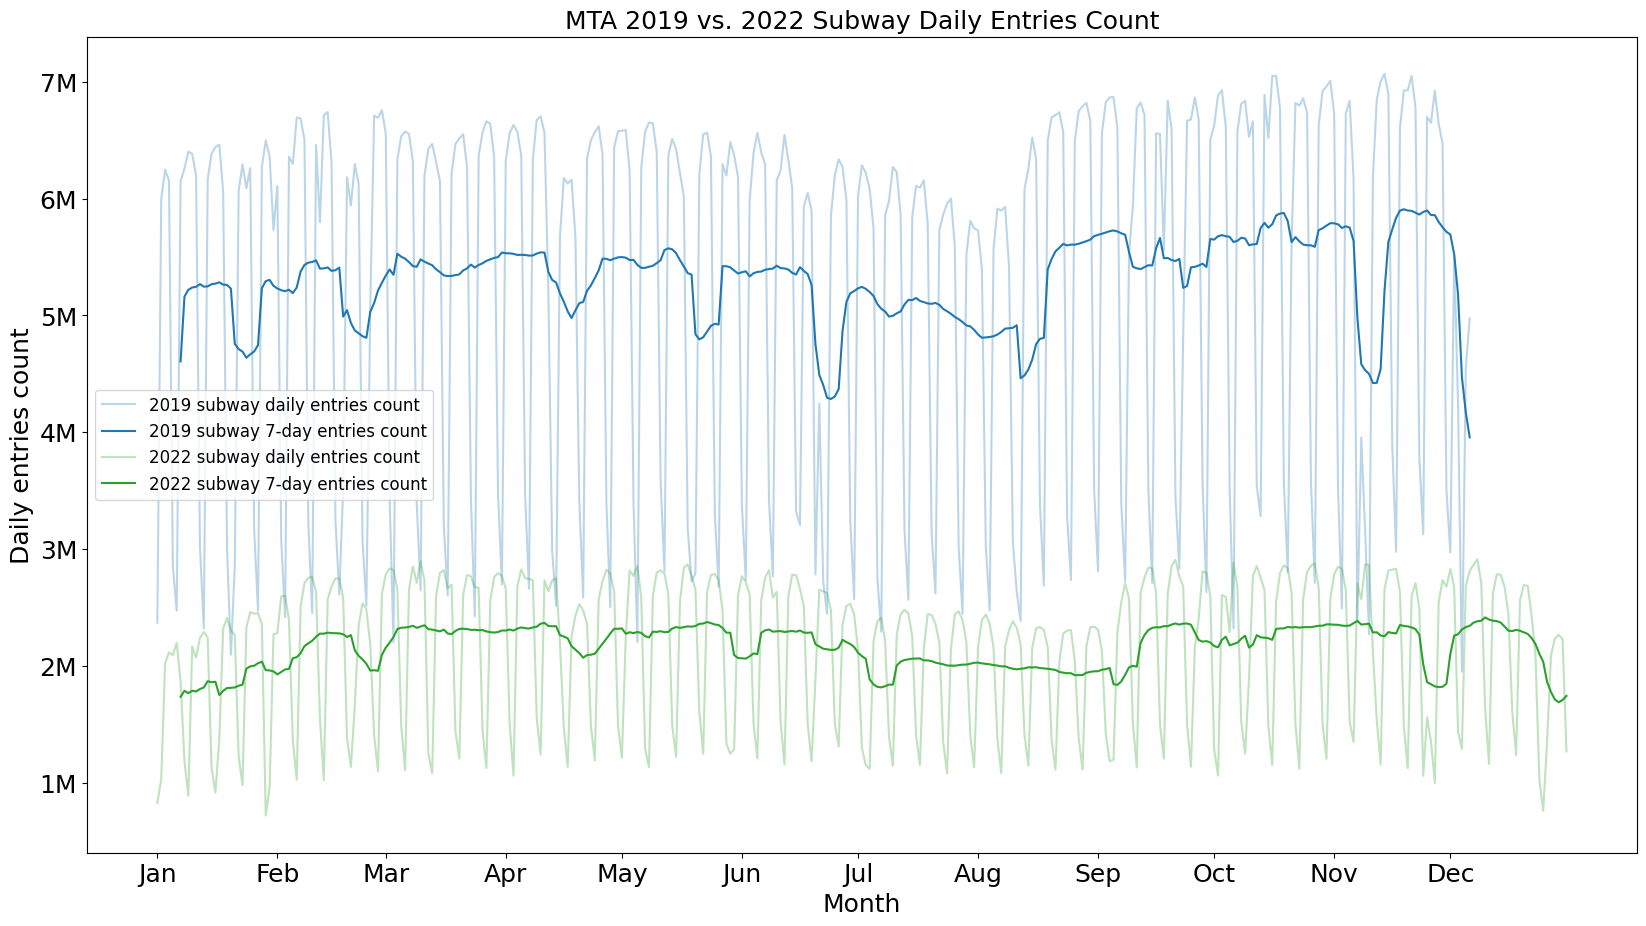

In [30]:
# set the size of the plot
plt.figure(figsize=(20, 12))

# generates a list of dates for 2022
dateList2022 = [str(datetime.date(2022, 1, 1) + datetime.timedelta(days=i)) for i in range(365)]

# color for 2019
blue = u'#1f77b4'

# color for 2020
orange = u'#ff7f0e'

# color for 2022
green = u'#2ca02c'

# plot data
plt.plot(dateList2022, total_daily_entry_count_2019_list, 
         label='2019 subway daily entries count', alpha = 0.3, color = blue)
plt.plot(dateList2022, entries_avg_2019, 
         label='2019 subway 7-day entries count', color = blue)
plt.plot(dateList2022, total_daily_entry_count_2022_list, 
         label='2022 subway daily entries count', alpha = 0.3, color = green)
plt.plot(dateList2022, entries_avg_2022, 
         label='2022 subway 7-day entries count', color = green)
plt.legend(fontsize=12)

# set plot title and axis labels
plt.title('MTA 2019 vs. 2022 Subway Daily Entries Count', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Daily entries count', fontsize=18)

# set x-tick labels to show abbreviated month names
dateRange = pd.date_range(start='2022-01-01', end='2022-12-31')
monthStarts = [date for date in dateRange if date.day == 1]
daysSinceStartOfYear = [(date - pd.Timestamp(date.year, 1, 1)).days for date in monthStarts]
monthNames = [date.strftime('%b') for date in monthStarts]
plt.xticks(daysSinceStartOfYear, monthNames, fontsize=18)

# adjust plot margins
plt.subplots_adjust(bottom=0.20)

# set y-tick fontsize
plt.yticks(fontsize=18)

# format y-tick labels as millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# show plot
plt.show()

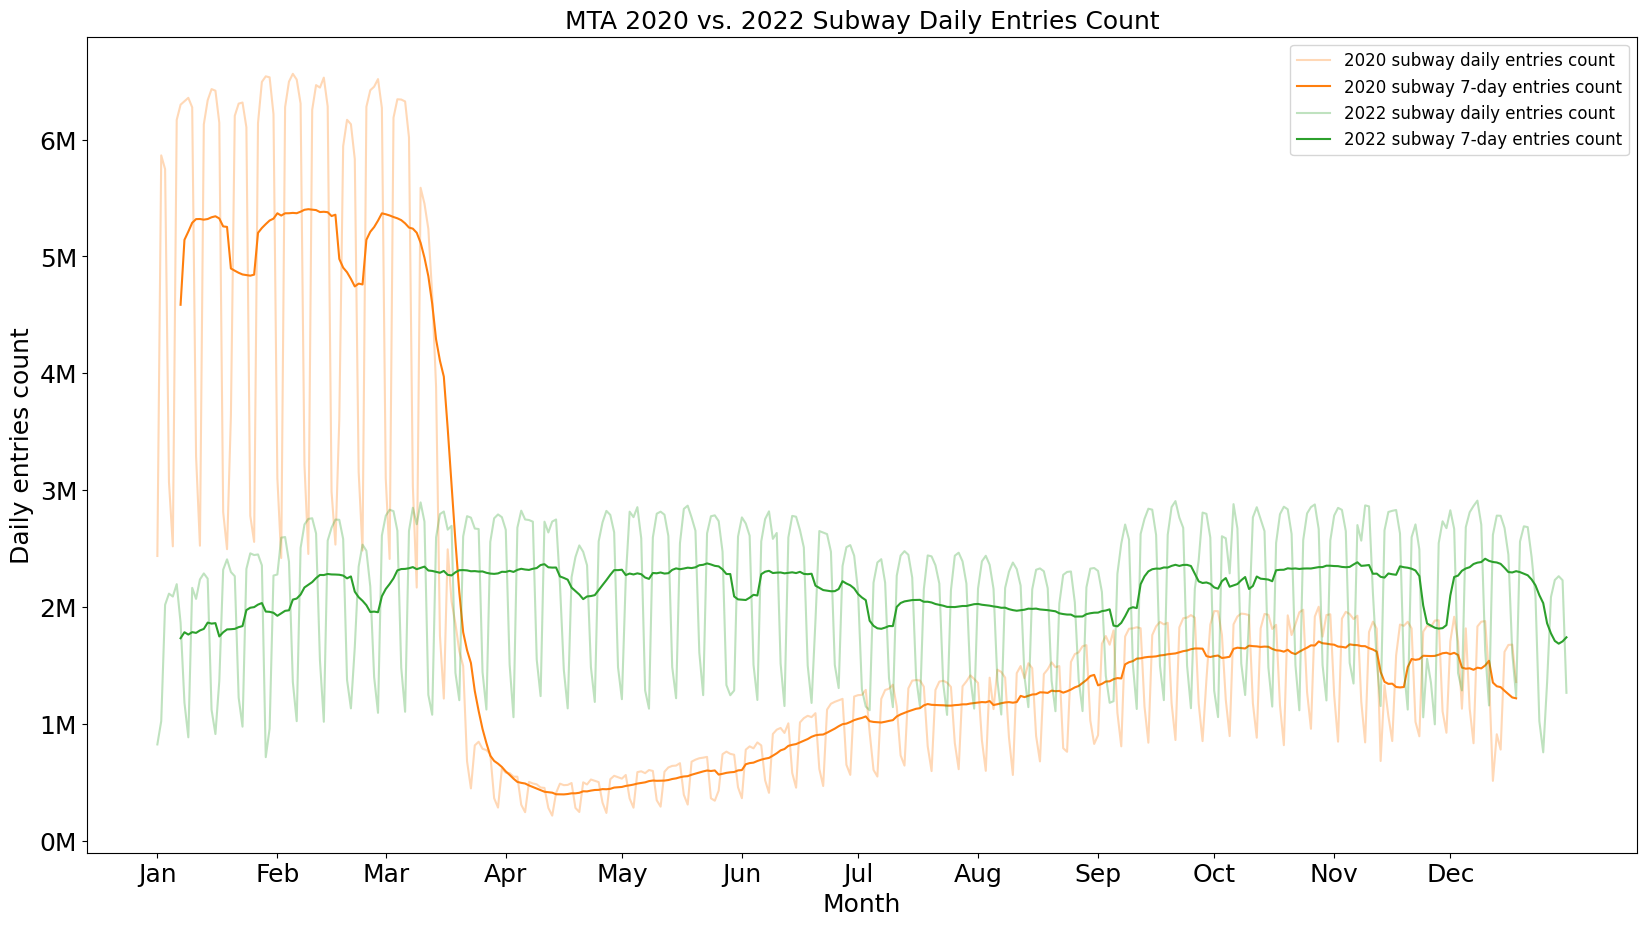

In [31]:
# set the size of the plot
plt.figure(figsize=(20, 12))

# plot data
plt.plot(dateList2022, total_daily_entry_count_2020_list, 
         label='2020 subway daily entries count', alpha = 0.3, color = orange)
plt.plot(dateList2022, entries_avg_2020, 
         label='2020 subway 7-day entries count', color = orange)
plt.plot(dateList2022, total_daily_entry_count_2022_list, 
         label='2022 subway daily entries count', alpha = 0.3, color = green)
plt.plot(dateList2022, entries_avg_2022, 
         label='2022 subway 7-day entries count', color = green)
plt.legend(fontsize=12)

# set plot title and axis labels
plt.title('MTA 2020 vs. 2022 Subway Daily Entries Count', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Daily entries count', fontsize=18)

# set x-tick labels to show abbreviated month names
plt.xticks(daysSinceStartOfYear, monthNames, fontsize=18)

# adjust plot margins
plt.subplots_adjust(bottom=0.20)

# set y-tick fontsize
plt.yticks(fontsize=18)

# format y-tick labels as millions
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# show plot
plt.show()